# Multi-document LangGraph with Redis Retrieval Agent using Ollama
[Retrieval Agents](https://python.langchain.com/docs/use_cases/question_answering/conversational_retrieval_agents) are useful when we want to make decisions about whether to retrieve from an index. Here we construct the same single index of 10Ks with metadata that we tried in notebook 04.

To implement a Redis retrieval agent, we simply need to give an LLM access to a Redis retriever tool.

We can incorporate this into [LangGraph](https://python.langchain.com/docs/langgraph).

In [1]:
import json
import os
import warnings
warnings.filterwarnings("ignore")
dir_path = os.getcwd()
parent_directory = os.path.dirname(dir_path)
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["ROOT_DIR"] = parent_directory
print(dir_path)
print(parent_directory)

/Users/rouzbeh.farahmand/PycharmProjects/commit/financial-vss/multi_doc_RAG
/Users/rouzbeh.farahmand/PycharmProjects/commit/financial-vss


In [2]:
!pip3 install -r $ROOT_DIR/requirements.txt

In [2]:
# Replace values below with your own if using Redis Cloud instance
REDIS_HOST = os.getenv("REDIS_HOST", "localhost")
REDIS_PORT = os.getenv("REDIS_PORT", "6379")
REDIS_PASSWORD = os.getenv("REDIS_PASSWORD", "")
os.environ["OPENAI_API_KEY"] = 'sk-proj-LjOKui5AFXvDfGcssZECT3BlbkFJeIIVTcAEqxFtNZztsQg1'
os.environ["NLTK_DATA"] = "/Users/rouzbeh.farahmand/nltk_data"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = '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'
# If SSL is enabled on the endpoint, use rediss:// as the URL prefix
REDIS_URL = f"redis://{REDIS_HOST}:{REDIS_PORT}"
os.environ["REDIS_URL"] = REDIS_URL

### SentenceTransformerEmbeddings Models Cache folder
We are using `SentenceTransformerEmbeddings` in this demo and here we specify the cache folder. If you already downloaded the models in a local file system, set this folder here, otherwise the library tries to download the models in this folder if not available locally.

In particular, these models will be downloaded if not present in the cache folder:

models/models--sentence-transformers--all-MiniLM-L6-v2

models/models--sentence-transformers--all-mpnet-base-v2


In [3]:
#setting the local downloaded sentence transformer models f
os.environ["TRANSFORMERS_CACHE"] = f"{parent_directory}/models"

In [4]:
from langchain.embeddings.sentence_transformer import SentenceTransformerEmbeddings

embeddings = SentenceTransformerEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2",
                                           cache_folder=os.getenv("TRANSFORMERS_CACHE", f"{parent_directory}/models"))

### Build your Redis index 
Skip this section if you have already built your index in previous notebook.


In [6]:
from redisvl.index import SearchIndex
from redisvl.schema import IndexSchema
from redis import Redis
index_name = 'langchain'
prefix = 'chunk'
schema = IndexSchema.from_yaml('sec_index.yaml')
client = Redis.from_url(REDIS_URL)
# create an index from schema and the client
index = SearchIndex(schema, client)
index.create(overwrite=True, drop=True)

19:18:42 redisvl.index.index INFO   Index already exists, overwriting.


In [9]:
# Skip if you have already done populated your index.
from ingestion import get_sec_data
from ingestion import redis_bulk_upload

sec_data = get_sec_data()

/Users/rouzbeh.farahmand/PycharmProjects/commit/financial-vss/multi_doc_RAG
/Users/rouzbeh.farahmand/PycharmProjects/commit/financial-vss
 ✅ Loaded doc info for  112 tickers...


In [10]:
redis_bulk_upload(sec_data, index, embeddings, tickers=['AAPL'])

✅ Loaded 108 10K chunks for ticker=AAPL from AAPL-2021-10K.pdf
✅ Loaded 94 10K chunks for ticker=AAPL from AAPL-2023-10K.pdf
✅ Loaded 103 10K chunks for ticker=AAPL from AAPL-2022-10K.pdf
✅ Loaded 27 earning_call chunks for ticker=AAPL from 2018-May-01-AAPL.txt
✅ Loaded 31 earning_call chunks for ticker=AAPL from 2019-Oct-30-AAPL.txt
✅ Loaded 30 earning_call chunks for ticker=AAPL from 2016-Jan-26-AAPL.txt
✅ Loaded 31 earning_call chunks for ticker=AAPL from 2020-Jul-30-AAPL.txt
✅ Loaded 30 earning_call chunks for ticker=AAPL from 2017-Aug-01-AAPL.txt
✅ Loaded 29 earning_call chunks for ticker=AAPL from 2020-Jan-28-AAPL.txt
✅ Loaded 34 earning_call chunks for ticker=AAPL from 2016-Apr-26-AAPL.txt
✅ Loaded 29 earning_call chunks for ticker=AAPL from 2017-Jan-31-AAPL.txt
✅ Loaded 28 earning_call chunks for ticker=AAPL from 2019-Apr-30-AAPL.txt
✅ Loaded 26 earning_call chunks for ticker=AAPL from 2017-Nov-02-AAPL.txt
✅ Loaded 31 earning_call chunks for ticker=AAPL from 2016-Oct-25-AAPL.tx

## Redis as a Retriever

First, we index 3 blog posts.

In [5]:
from langchain_community.vectorstores import Redis as LangChainRedis
from utils import create_langchain_schemas_from_redis_schema

index_name = 'langchain'

vec_schema , main_schema = create_langchain_schemas_from_redis_schema('sec_index.yaml')

rds = LangChainRedis.from_existing_index( embedding = embeddings, 
                                          index_name = index_name, 
                                          schema = main_schema)
redis_retriever = rds.as_retriever()


Test if the Redis index is working and returning relevant document.

In [6]:
rds.similarity_search(query="Apple in 2022", k=4, distance_threshold=0.8)

[Document(page_content='The Company’s global operations are subject to complex and changing laws and regulations on subjects, including antitrust; privacy, data security and data localization; consumer protection; advertising, sales, billing and e-commerce; financial services and technology; product liability; intellectual property ownership and infringement; digital platforms; internet, telecommunications, and mobile communications; media, television, film and digital content; availability of third-party software applications and services; labor and employment; anticorruption; import, export and trade; foreign exchange controls and cash repatriation restrictions; anti–money laundering; foreign ownership and investment; tax; and environmental, health and safety, including electronic waste, recycling, and climate change.\n\nApple Inc. | 2022 Form 10-K | 13', metadata={'id': 'chunk:AAPL-2022-10K.pdf-9925c2e6-e67c-4e39-929b-989b3c8d6cf0', 'chunk_id': 'AAPL-2022-10K.pdf-9925c2e6-e67c-4e39-

Now we create a Redis retriever tool.

In [18]:
from langchain_core.tools import Tool
from langchain_experimental.llms.ollama_functions import OllamaFunctions

ollama_model = OllamaFunctions(model="llama3", format="json")

"""    
from functools import partial

def ask_question(question):
    response = rds.similarity_search(query=question, k=4, distance_threshold=0.8)
    print(response.page_content)
    result = {
        "output": response.page_content
    }
    return result

get_financials_docs_from_redis = partial(ask_question, 1)

redis_retriever_tool_ollama = Tool(
        name="get_financials_docs_from_redis",
        description="Redis Similarity Search Tool",
        func=get_financials_docs_from_redis
    )
"""
from langchain.tools.retriever import create_retriever_tool

redis_retriever_tool_ollama = create_retriever_tool(
    redis_retriever,
    "get_financials_docs_from_redis",
    "Redis Similarity Search Tool",
)



ollama_tools = [redis_retriever_tool_ollama]

from langgraph.prebuilt import ToolExecutor

ollama_tools_executor = ToolExecutor(ollama_tools)

In [19]:
#type(redis_retriever_tool)

In [20]:
#redis_retriever_tool.to_json()

## Agent state
 
We will defined a graph.

A `state` object that it passes around to each node.

Our state will be a list of `messages`.

Each node in our graph will append to it.

In [21]:
from typing import Annotated, Sequence, TypedDict

from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages


class AgentState(TypedDict):
    # The add_messages function defines how an update should be processed
    # Default is to replace. add_messages says "append"
    messages: Annotated[Sequence[BaseMessage], add_messages]

## Nodes and Edges

We can lay out an agentic RAG graph like this:

* The state is a set of messages
* Each node will update (append to) state
* Conditional edges decide which node to visit next

![diagram1.png](diagram1.png)
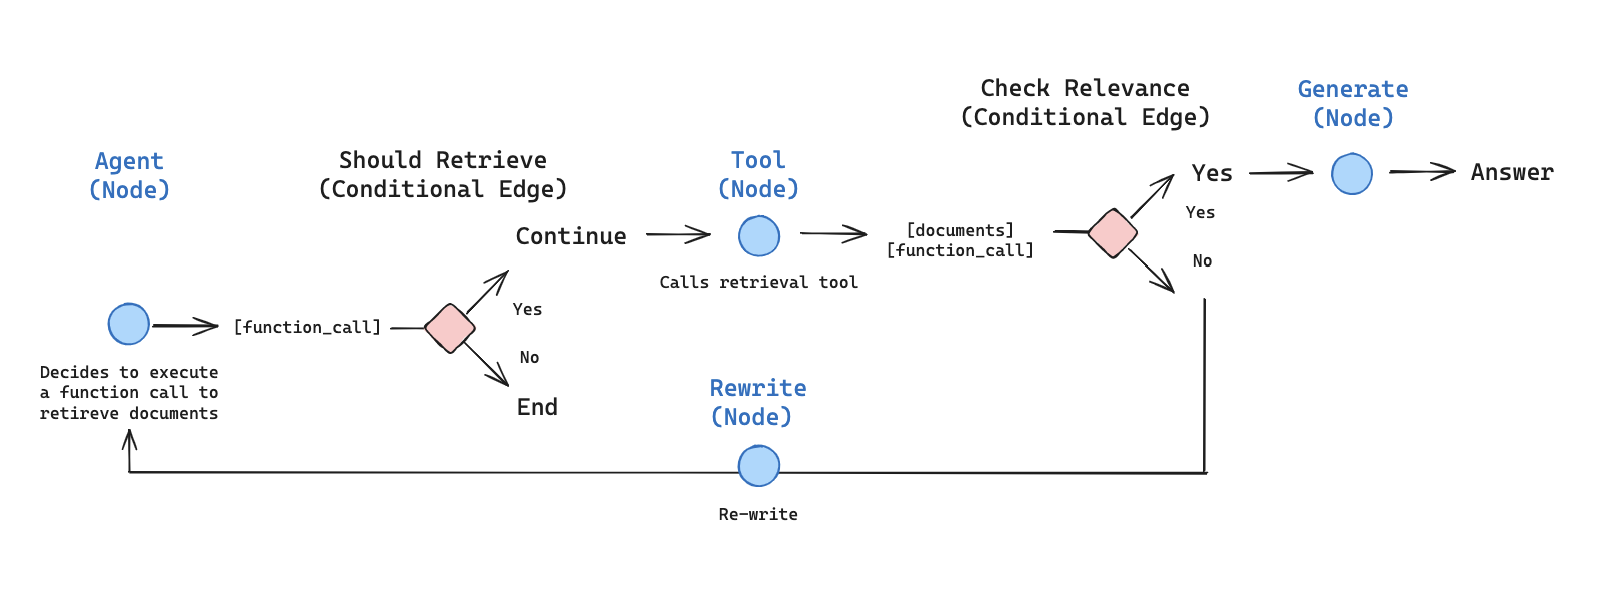

In [22]:
from typing import Annotated, Literal, Sequence, TypedDict

from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import tools_condition
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate, HumanMessagePromptTemplate
# LangChain supports many other chat models. Here, we're using Ollama
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

# supports many more optional parameters. Hover on your `ChatOllama(...)`
# class to view the latest available supported parameters

### Edges


def grade_documents(state) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    print("---CHECK RELEVANCE---")

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""

        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # LLM
    model = ChatOllama(model="llama3") #ChatOpenAI(temperature=0, model="gpt-4-0125-preview", streaming=True)

    # LLM with tool and validation
    llm_with_tool = model.with_structured_output(grade)

    # Prompt
    local_prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    # Chain
    chain = local_prompt | llm_with_tool

    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content
    
    print(docs)

    scored_result = chain.invoke({"question": question, "context": docs})

    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"

    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score)
        return "rewrite"


### Nodes


def agent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")
    messages = state["messages"]
    model = ChatOpenAI(temperature=0, streaming=True, model="gpt-4-turbo")
    model = model.bind_tools(ollama_tools)
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n 
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # Grader
    model = ChatOllama(model="llama3") #ChatOpenAI(temperature=0, model="gpt-4-0125-preview", streaming=True)
    response = model.invoke(msg)
    return {"messages": [response]}


def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with re-phrased question
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    # Prompt
    #prompt = hub.pull("rlm/rag-prompt")
    local_prompt = ChatPromptTemplate(
        input_variables=['context', 'question'], 
        messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"))])

    # LLM
    llm = ChatOllama(model="llama3") #ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0, streaming=True)

    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Chain
    rag_chain = local_prompt | llm | StrOutputParser()

    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}


#print("*" * 20 + "Prompt[rlm/rag-prompt]" + "*" * 20)
#prompt = hub.pull("rlm/rag-prompt").pretty_print()  # Show what the prompt looks like

## Graph

* Start with an agent, `call_model`
* Agent make a decision to call a function
* If so, then `action` to call tool (retriever)
* Then call agent with the tool output added to messages (`state`)

In [26]:
from langgraph.graph import END, StateGraph
from langgraph.prebuilt import ToolNode

# Define a new graph
workflow = StateGraph(AgentState)

# Define the nodes we will cycle between
workflow.add_node("agent", agent)  # agent
ollama_retrieve = ToolNode([redis_retriever_tool_ollama])
workflow.add_node("ollama_redis_retrieve", ollama_retrieve)  # retrieval
workflow.add_node("rewrite", rewrite)  # Re-writing the question
workflow.add_node(
    "generate", generate
)  # Generating a response after we know the documents are relevant
# Call agent node to decide to retrieve or not
workflow.set_entry_point("agent")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "agent",
    # Assess agent decision
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "ollama_tools": "ollama_redis_retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "ollama_redis_retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

# Compile
graph = workflow.compile()

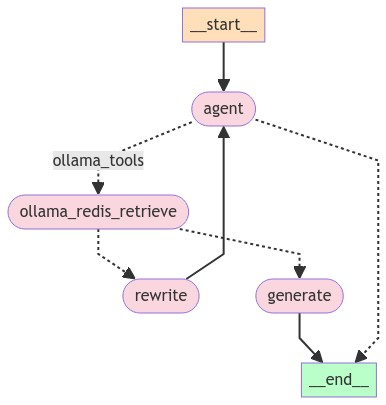

In [27]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

In [28]:
import pprint

inputs = {
    "messages": [
        ("user", "What was the performance of Apple revenue in 2022?"),
    ]
}
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---CALL AGENT---


KeyError: 'tools'